<a href="https://colab.research.google.com/github/manan-garg/Personalized_Recommender_System/blob/main/Personalized_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement:

To build a personalized movie recommendation system by taking into account a user's ratings and those of other users with similar preferences so as to enhance the user experience.

In [ ]:
# Importing libraries -
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Loading Datasets

In [ ]:
# Loading the ratings dataset -
ratings_df = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
ratings_df[['UserID','MovieID','Rating',
            'Rating_Timestamp']] = ratings_df['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
ratings_df.drop('UserID::MovieID::Rating::Timestamp',axis=1,inplace=True)
ratings_df.head()

,UserID,MovieID,Rating,Rating_Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
# Loading the users dataset -
user_df = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')
user_df[['UserID','Gender','Age','Occupation',
         'Zip_code']] = user_df['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
user_df.drop('UserID::Gender::Age::Occupation::Zip-code',axis=1,inplace=True)
user_df.replace({'Age':{'1': "Under 18",
                        '18': "18-24",
                        '25': "25-34",
                        '35': "35-44",
                        '45': "45-49",
                        '50': "50-55",
                        '56': "56 Above"},
                'Occupation':{'0': "other",
                            '1': "academic/educator",
                            '2': "artist",
                            '3': "clerical/admin",
                            '4': "college/grad student",
                            '5': "customer service",
                            '6': "doctor/health care",
                            '7': "executive/managerial",
                            '8': "farmer",
                            '9': "homemaker",
                            '10': "K-12 student",
                            '11': "lawyer",
                            '12': "programmer",
                            '13': "retired",
                            '14': "sales/marketing",
                            '15': "scientist",
                            '16': "self-employed",
                            '17': "technician/engineer",
                            '18': "tradesman/craftsman",
                            '19': "unemployed",
                            '20': "writer"}}, inplace=True)
user_df.head()

,UserID,Gender,Age,Occupation,Zip_code
0,1,F,Under 18,K-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [ ]:
# Loading the movies dataset -
movies_df = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
movies_df[['MovieID','Title','Genres']] = movies_df['Movie ID::Title::Genres'].str.split('::',expand=True)
movies_df.drop(['Movie ID::Title::Genres','Unnamed: 1','Unnamed: 2'],axis=1,inplace=True)
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Cretaing the final dataframe by merging the datasets loaded
df = ratings_df.merge(user_df)
df = df.merge(movies_df)
df.head()

,UserID,MovieID,Rating,Rating_Timestamp,Gender,Age,Occupation,Zip_code,Title,Genres
0,1,1193,5,978300760,F,Under 18,K-12 student,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56 Above,self-employed,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25-34,programmer,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25-34,executive/managerial,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50-55,academic/educator,95350,One Flew Over the Cuckoo's Nest (1975),Drama


### Basic Metrics and Analysis

In [ ]:
# Shape of the dataset -
df.shape

(1000209, 10)

In [ ]:
# basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   UserID            1000209 non-null  object
 1   MovieID           1000209 non-null  object
 2   Rating            1000209 non-null  object
 3   Rating_Timestamp  1000209 non-null  object
 4   Gender            1000209 non-null  object
 5   Age               1000209 non-null  object
 6   Occupation        1000209 non-null  object
 7   Zip_code          1000209 non-null  object
 8   Title             1000209 non-null  object
 9   Genres            996144 non-null   object
dtypes: object(10)
memory usage: 83.9+ MB


In [ ]:
# conversion into relevant datatypes
df = df.astype({"UserID": int, "MovieID": int, "Rating": 'category', "Gender": 'category',
                "Age": 'category', "Occupation": 'category'})

In [ ]:
# Checking data types -
df.dtypes

UserID                 int64
MovieID                int64
Rating              category
Rating_Timestamp      object
Gender              category
Age                 category
Occupation          category
Zip_code              object
Title                 object
Genres                object
dtype: object

In [ ]:
#Checking which columns have null values
(df.isnull().sum()/len(df))*100

UserID              0.000000
MovieID             0.000000
Rating              0.000000
Rating_Timestamp    0.000000
Gender              0.000000
Age                 0.000000
Occupation          0.000000
Zip_code            0.000000
Title               0.000000
Genres              0.406415
dtype: float64

It can be observed that 'Genres' column has 0.40 % of null values. As this is a very small percentage of total data, we can drop those records.

In [ ]:
# dropping rows with null values
df.dropna(inplace=True)

In [ ]:
# dropping rows which have no Genre
df = df[df['Genres']!='']

In [ ]:
#Checking again which columns have null values
(df.isnull().sum()/len(df))*100

UserID              0.0
MovieID             0.0
Rating              0.0
Rating_Timestamp    0.0
Gender              0.0
Age                 0.0
Occupation          0.0
Zip_code            0.0
Title               0.0
Genres              0.0
dtype: float64

In [ ]:
# Checking for duplicate rows
df.duplicated().sum()

0

No duplicate rows present.

### Feature Engineering

In [ ]:
# Creation of 'Release_Year' column
df['Release_Year'] = df.Title.str[-5:-1]
df['Release_Year'] = df['Release_Year'].astype(int)
df.head()

,UserID,MovieID,Rating,Rating_Timestamp,Gender,Age,Occupation,Zip_code,Title,Genres,Release_Year
0,1,1193,5,978300760,F,Under 18,K-12 student,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,2,1193,5,978298413,M,56 Above,self-employed,70072,One Flew Over the Cuckoo's Nest (1975),Drama,1975
2,12,1193,4,978220179,M,25-34,programmer,32793,One Flew Over the Cuckoo's Nest (1975),Drama,1975
3,15,1193,4,978199279,M,25-34,executive/managerial,22903,One Flew Over the Cuckoo's Nest (1975),Drama,1975
4,17,1193,5,978158471,M,50-55,academic/educator,95350,One Flew Over the Cuckoo's Nest (1975),Drama,1975


### Visual Analysis

<AxesSubplot:xlabel='Release_Year', ylabel='Density'>

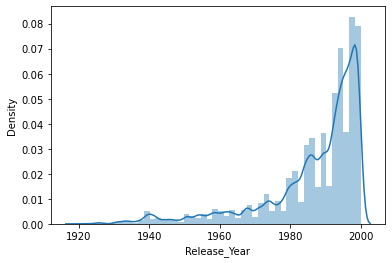

In [ ]:
#distplot for Continuous Variable
sns.distplot(df.Release_Year)

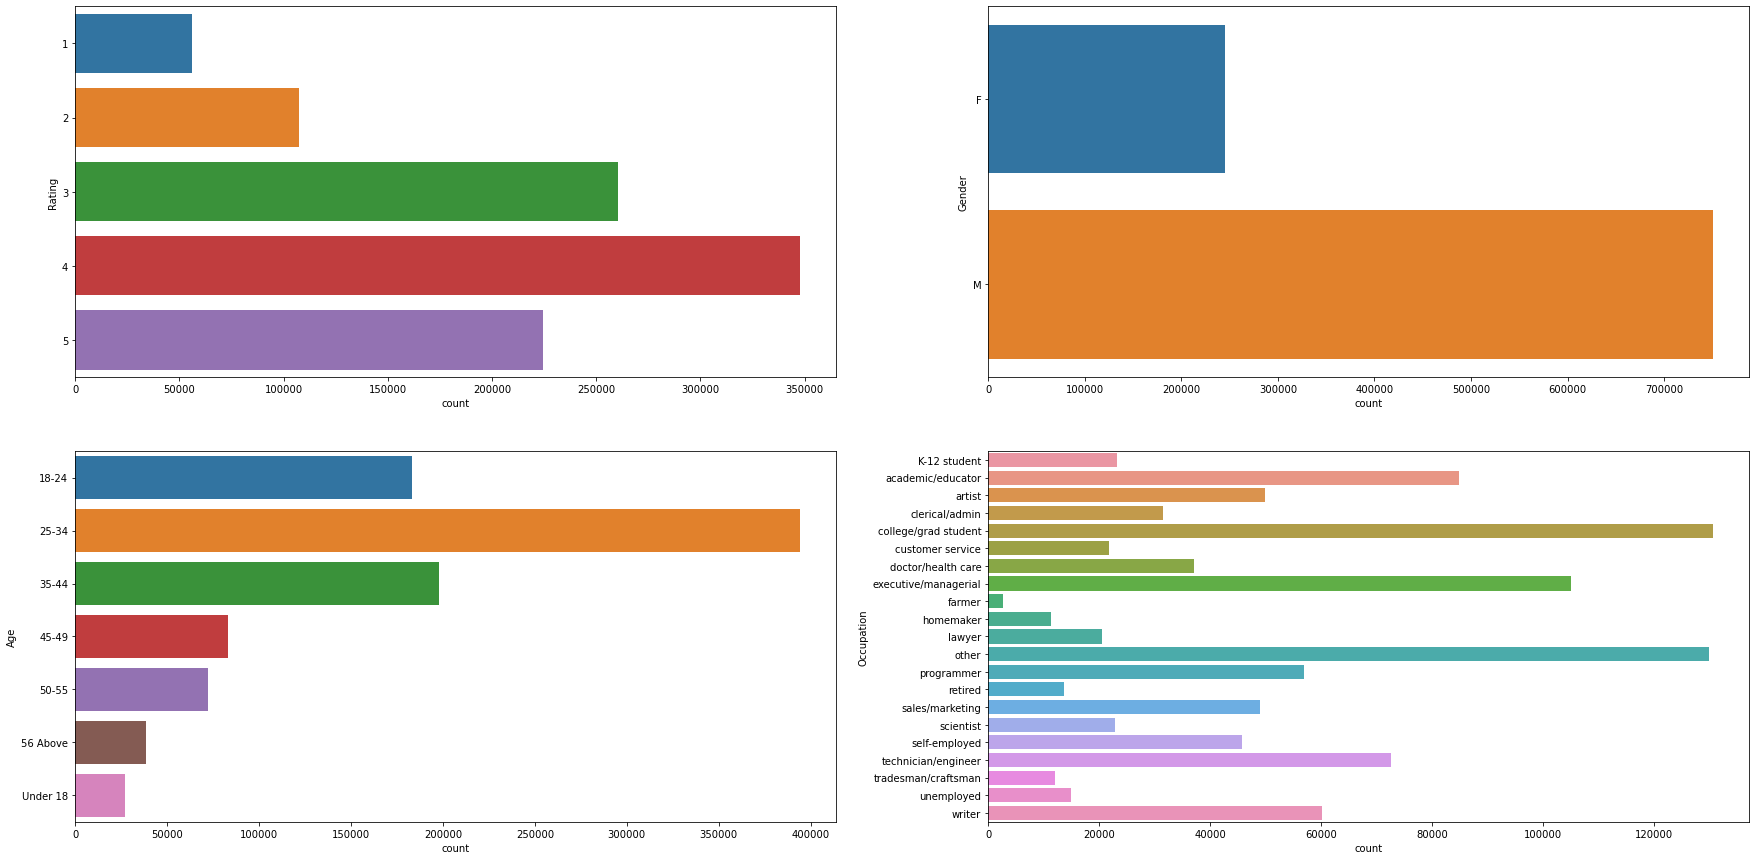

In [ ]:
# countplot for categorical columns
fig,axes=plt.subplots(2,2,figsize=(30, 15))
cols=['Rating', 'Gender', 'Age', 'Occupation']
for x in range(len(cols)):
    p=sns.countplot(y=df[cols[x]],ax=axes[x//2,x%2])

In [ ]:
# creating temperorary dataframe to get unique genres
df_temp = df.copy()
df_temp['Genres'] = df_temp.Genres.apply(lambda x: x.split('|'))
df_temp = df_temp.explode('Genres')

In [ ]:
# dropping rows which have no Genre in df_temp
df_temp = df_temp[df_temp['Genres']!='']

In [ ]:
# replacing genres with relevant values in df_temp
df_temp.replace({'Genres':{'Sci-F': "Sci-Fi",
                        'Fantas': "Fantasy",
                        'Adventur': "Adventure",
                        'Adventu': "Adventure",
                        'Th': "Thriller",
                        'S': "Sci-Fi",
                        'Film-Noir': "Film-Noir",
                        'Adv': "Adventure",
                        'Horro': "Horror",
                        'R': "Romance",
                        "Children'": "Children's",
                        'Comed': "Comedy",
                        'Com': "Comedy",
                        'Dram': "Drama",
                        'Fant': "Fantasy",
                        'Sci-': "Sci-Fi",
                        'Ro': "Romance",
                        'Children': "Children's",
                        'Docu': "Documentary",
                        'Roman': "Romance",
                        'Sci': "Sci-Fi",
                        'Dr': "Drama",
                        'Thrille': "Thriller",
                        'Come': "Comedy",
                        'Thri': "Thriller",
                        'Wester': "Western",
                        'Childre': "Children's",
                        'Advent': "Adventure",
                        'We': "Western",
                        'Chi': "Children's",
                        'Rom': "Romance",
                        'Wa': "War",
                        'Chil': "Children's",
                        'Childr': "Children's",
                        'Roma': "Romance",
                        'Documenta': "Documentary",
                        'Animati': "Animation",
                        'Horr': "Horror",
                        'Acti': "Action",
                        'Document': "Documentary",
                        'Documen': "Documentary",
                        'D': "Drama",
                        'A': "Animation",
                        'F': "Fantasy"}}, inplace=True)

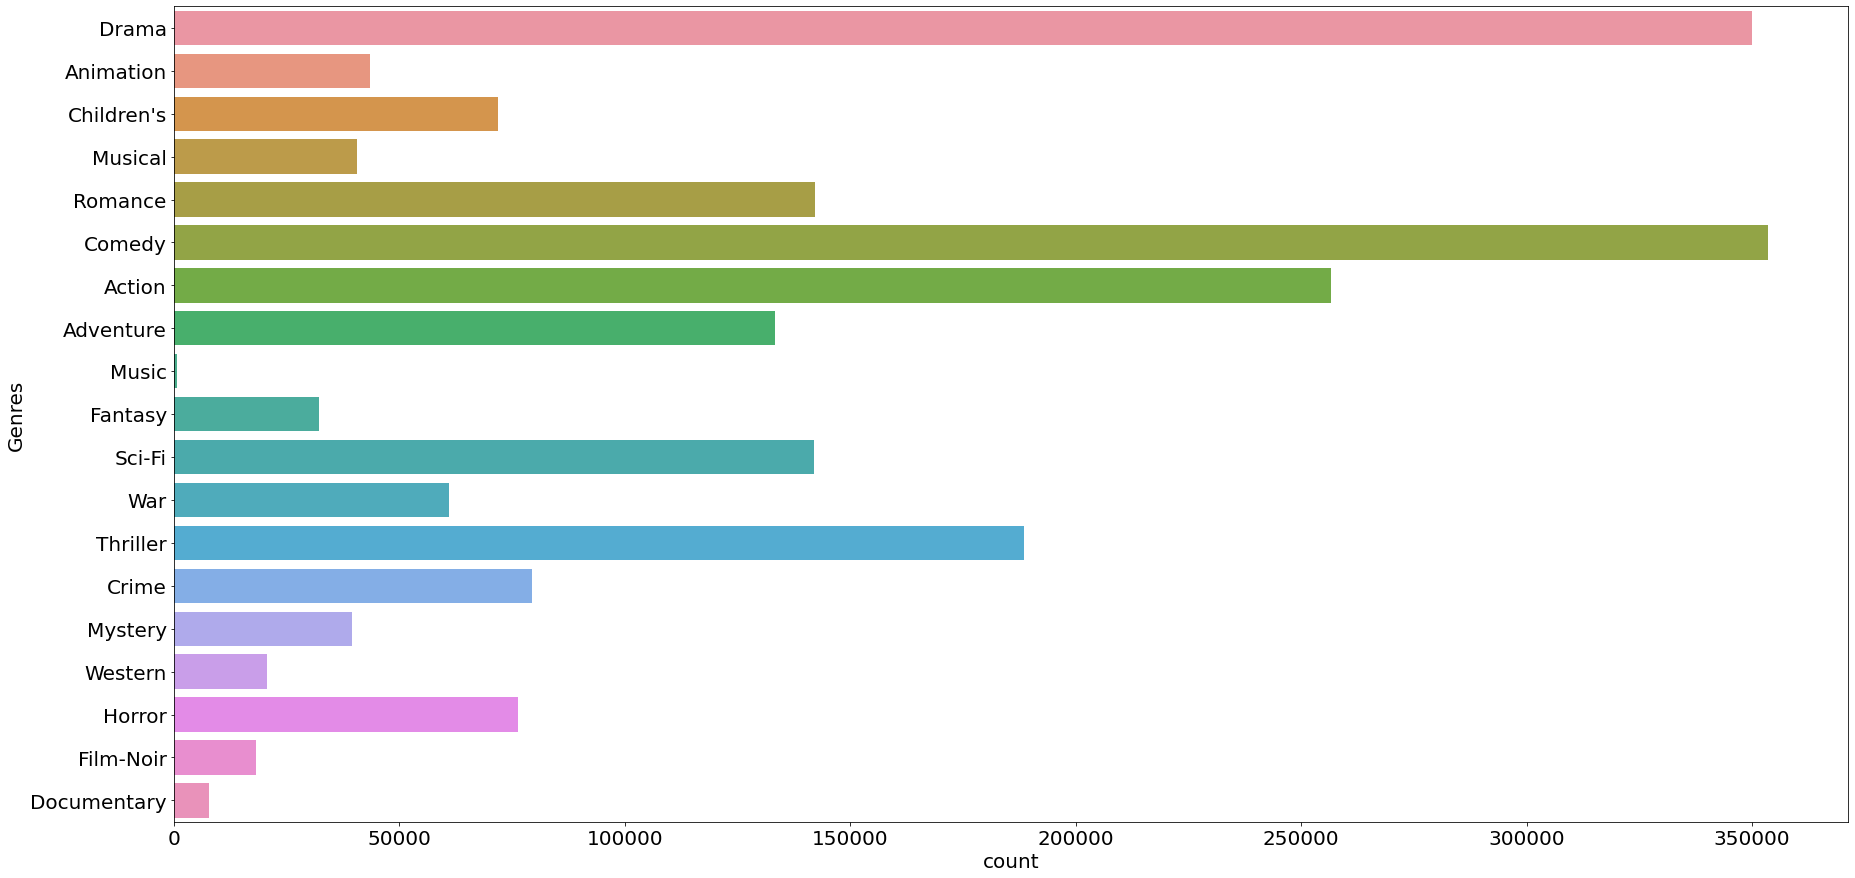

In [ ]:
# countplot for Genre
fig, ax = plt.subplots(figsize=(30, 15))
b = sns.countplot(y=df_temp['Genres'],ax=ax)
b.set_xlabel("count",fontsize=20)
b.set_ylabel("Genres",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

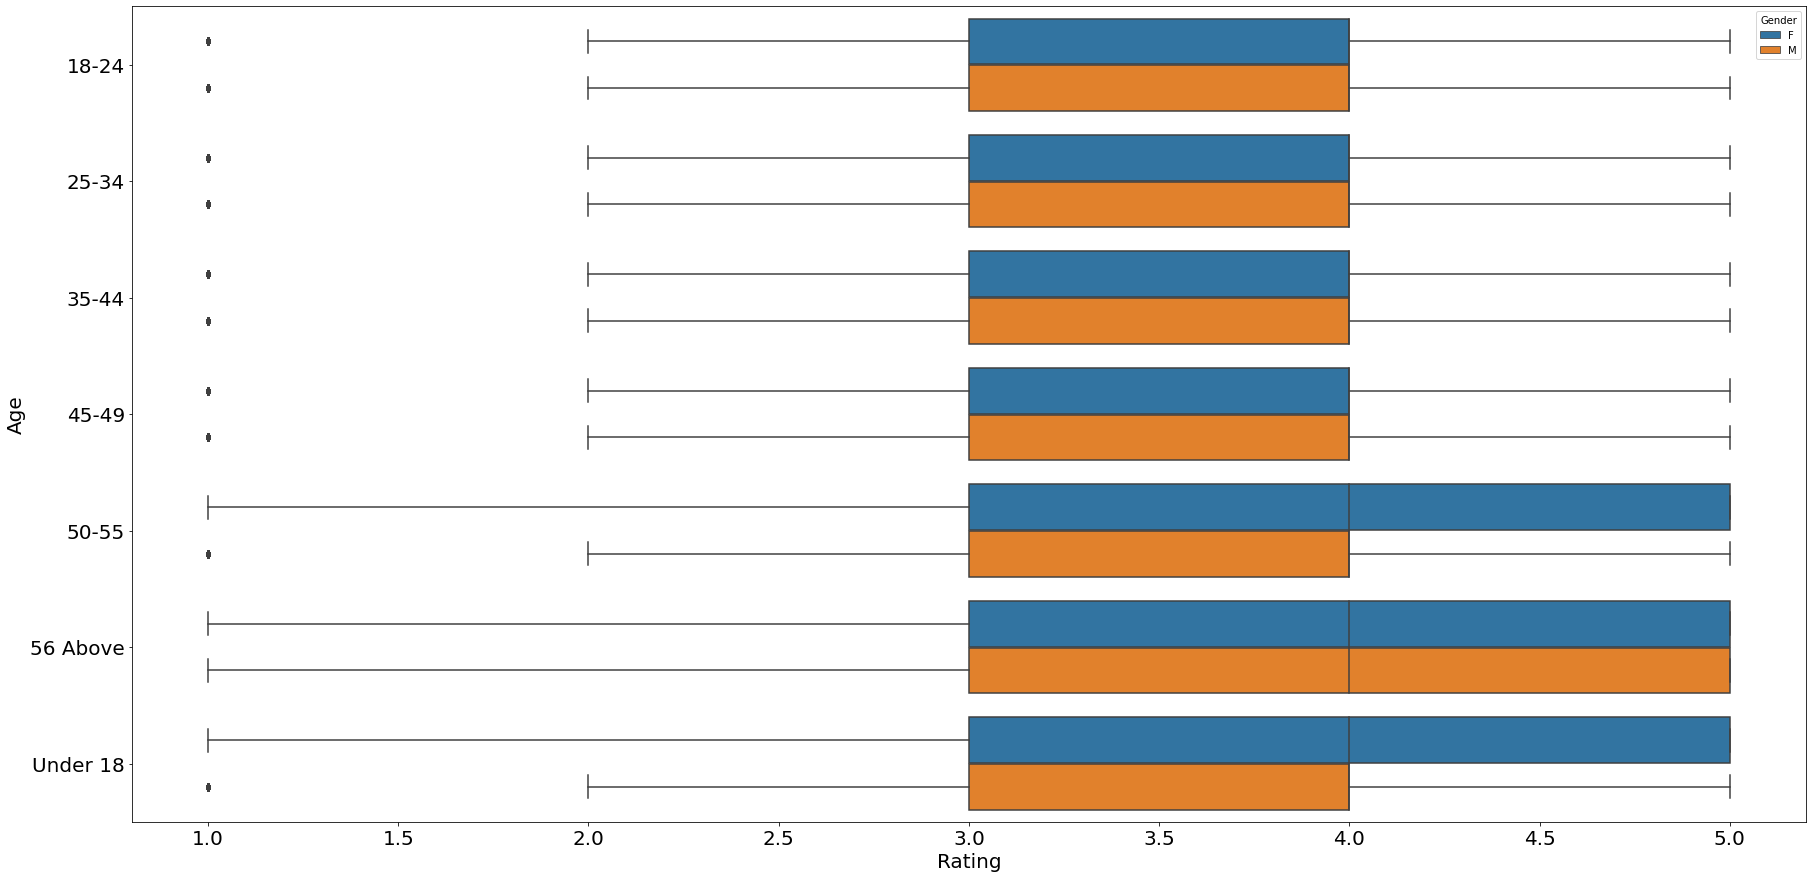

In [ ]:
# Ist boxplot between Rating, Age and Gender
fig, ax = plt.subplots(figsize=(30, 15))
b = sns.boxplot(df.Rating.astype(int),df.Age,hue=df.Gender,ax=ax)
b.set_xlabel("Rating",fontsize=20)
b.set_ylabel("Age",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

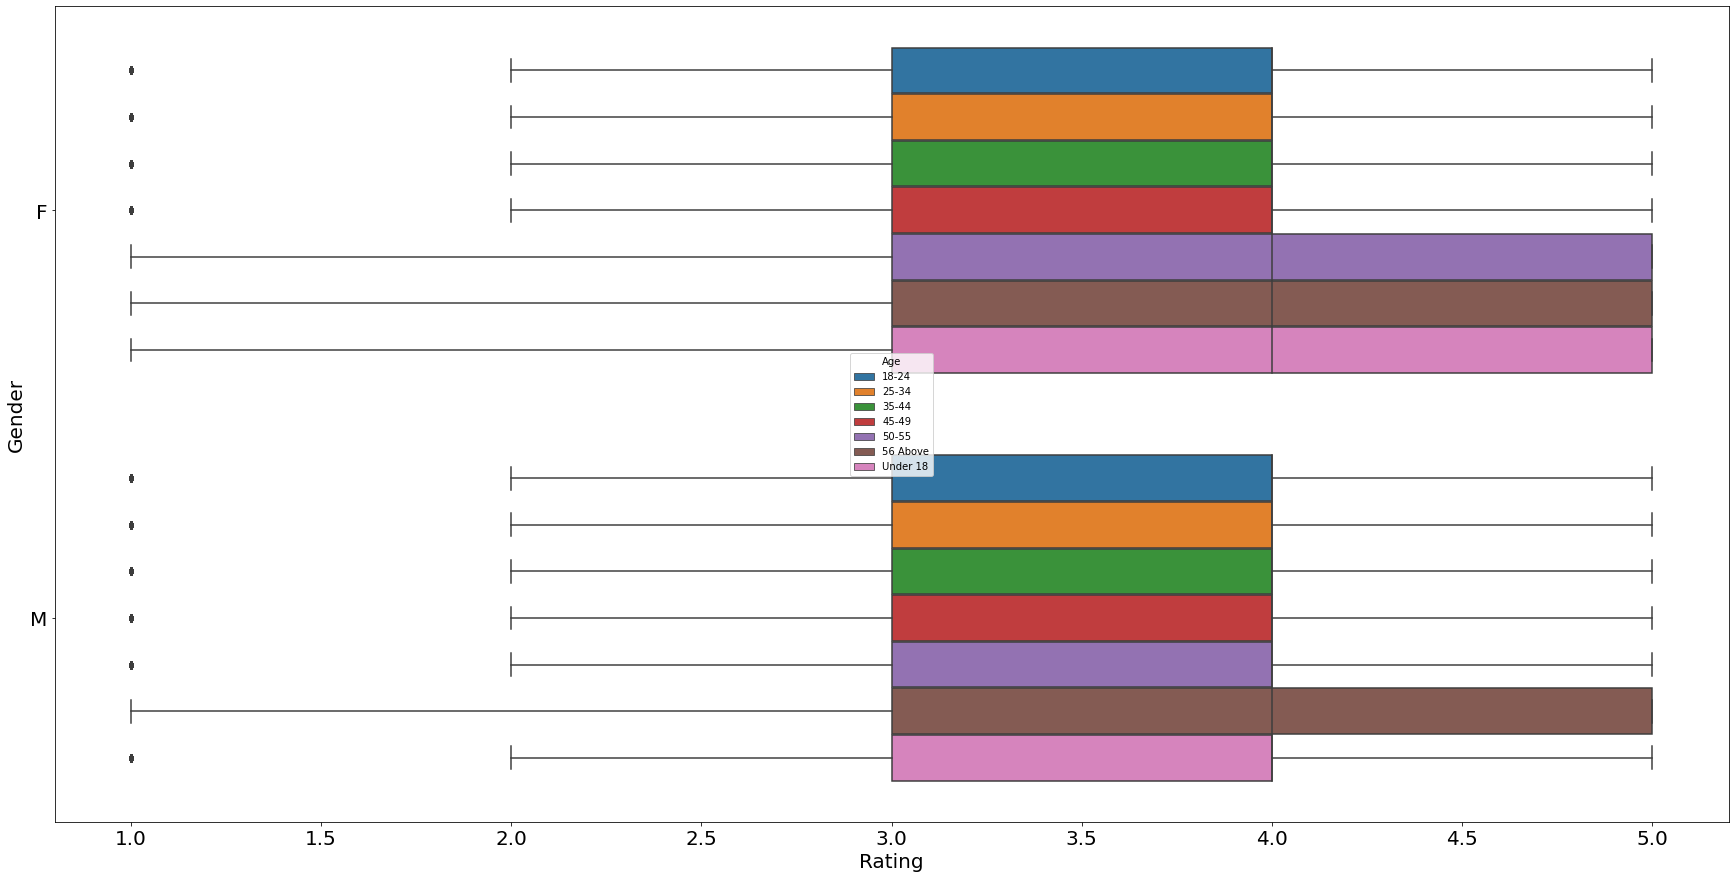

In [ ]:
# IInd boxplot between Rating, Age and Gender
fig, ax = plt.subplots(figsize=(30, 15))
b = sns.boxplot(df.Rating.astype(int),df.Gender,hue=df.Age,ax=ax)
b.set_xlabel("Rating",fontsize=20)
b.set_ylabel("Gender",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

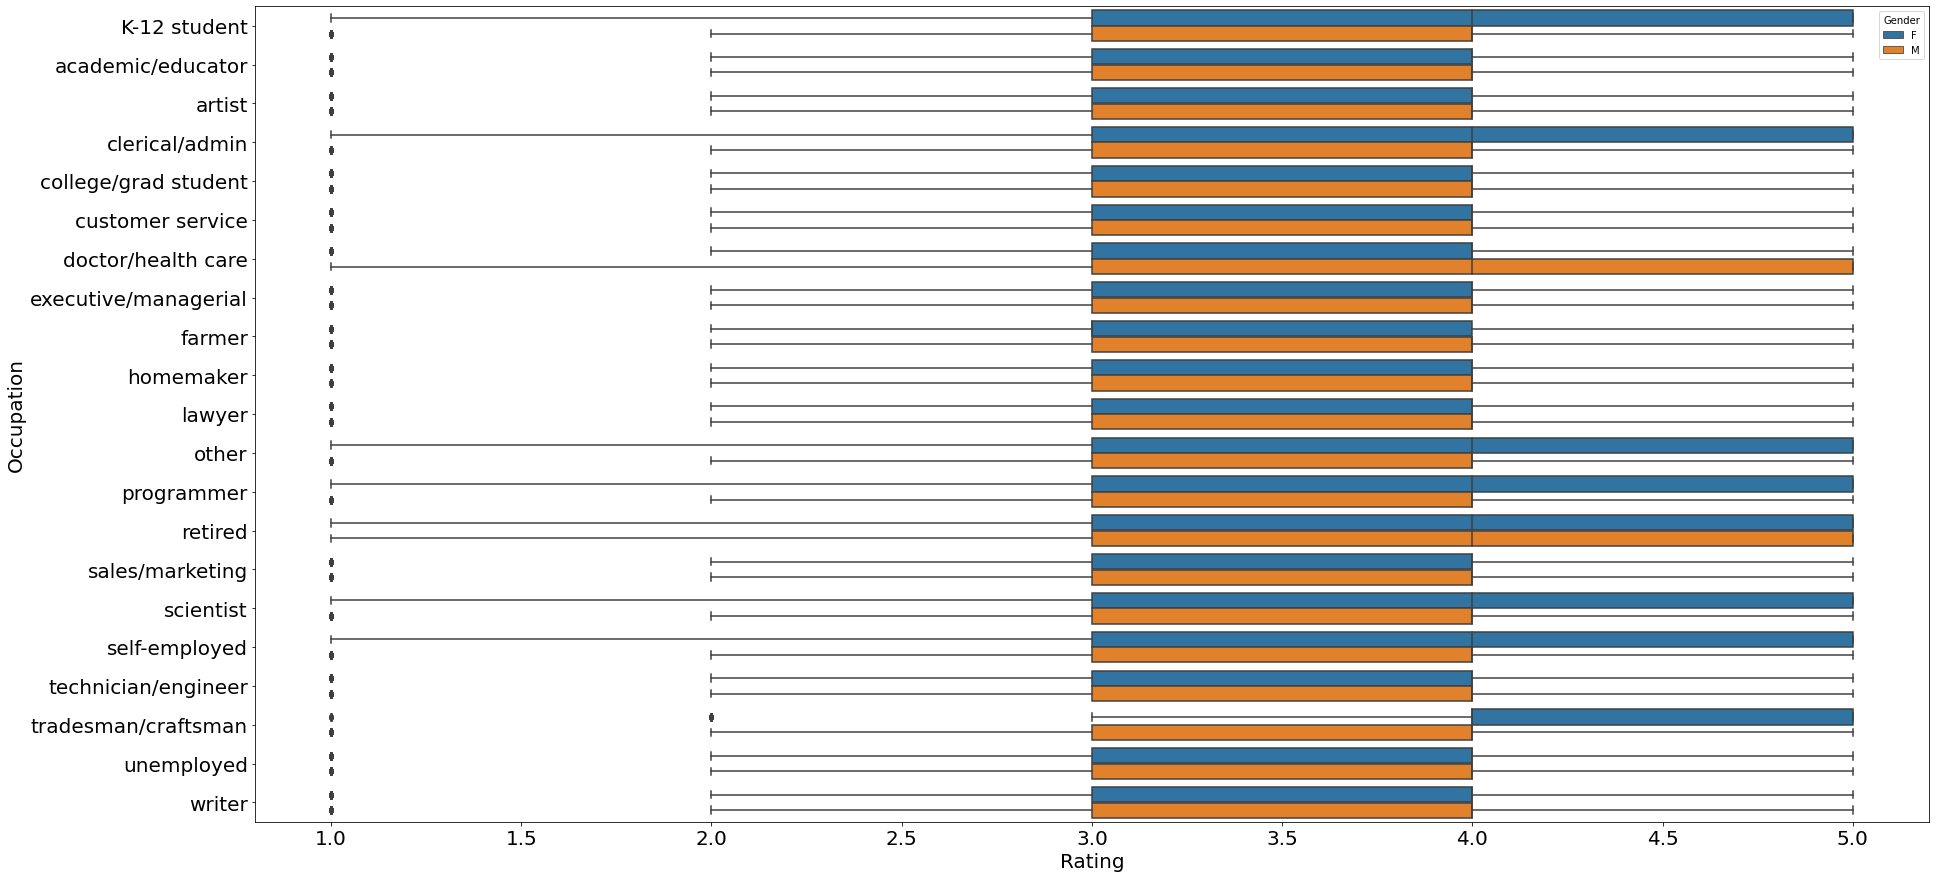

In [ ]:
# boxplot between Rating, Occupation and Gender
fig, ax = plt.subplots(figsize=(30, 15))
b = sns.boxplot(df.Rating.astype(int),df.Occupation,hue=df.Gender, ax=ax)
b.set_xlabel("Rating",fontsize=20)
b.set_ylabel("Occupation",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

#### Grouping the data in terms of Average Rating

In [ ]:
# Converting Rating column as int
df['Rating'] = df['Rating'].astype(int)
df_temp['Rating'] = df_temp['Rating'].astype(int)

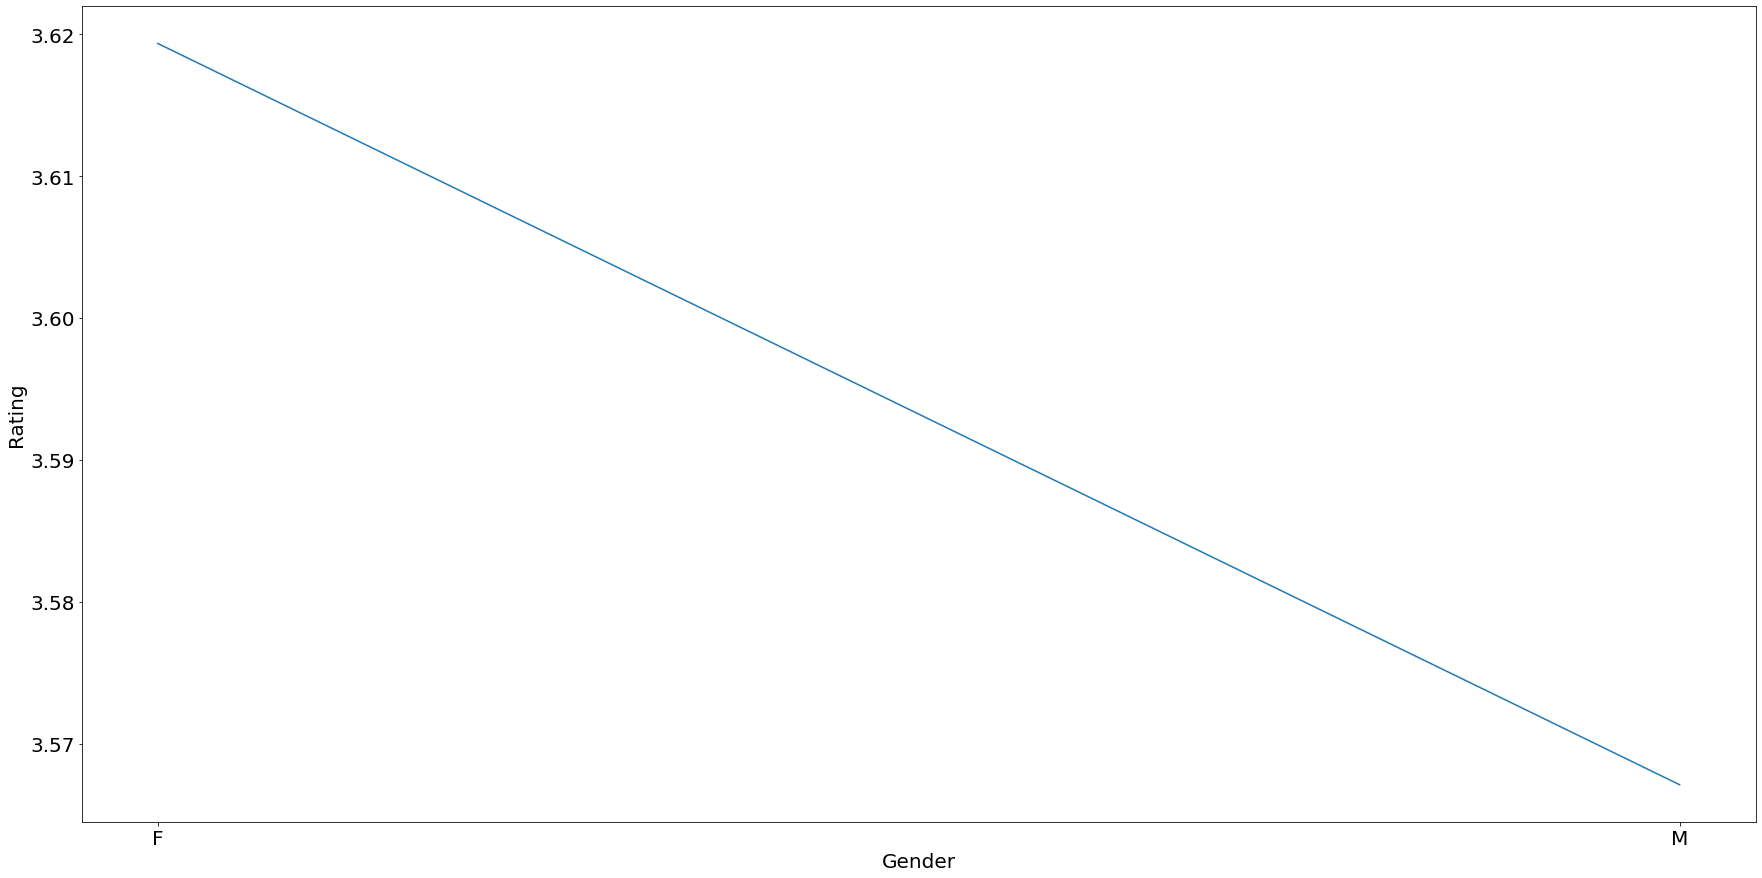

In [ ]:
# lineplot of Gender with average rating
i='Gender'
fig, ax = plt.subplots(figsize=(30, 15))
df_avg_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['mean']})
df_avg_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_avg_rating)
b.set_xlabel("Gender",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

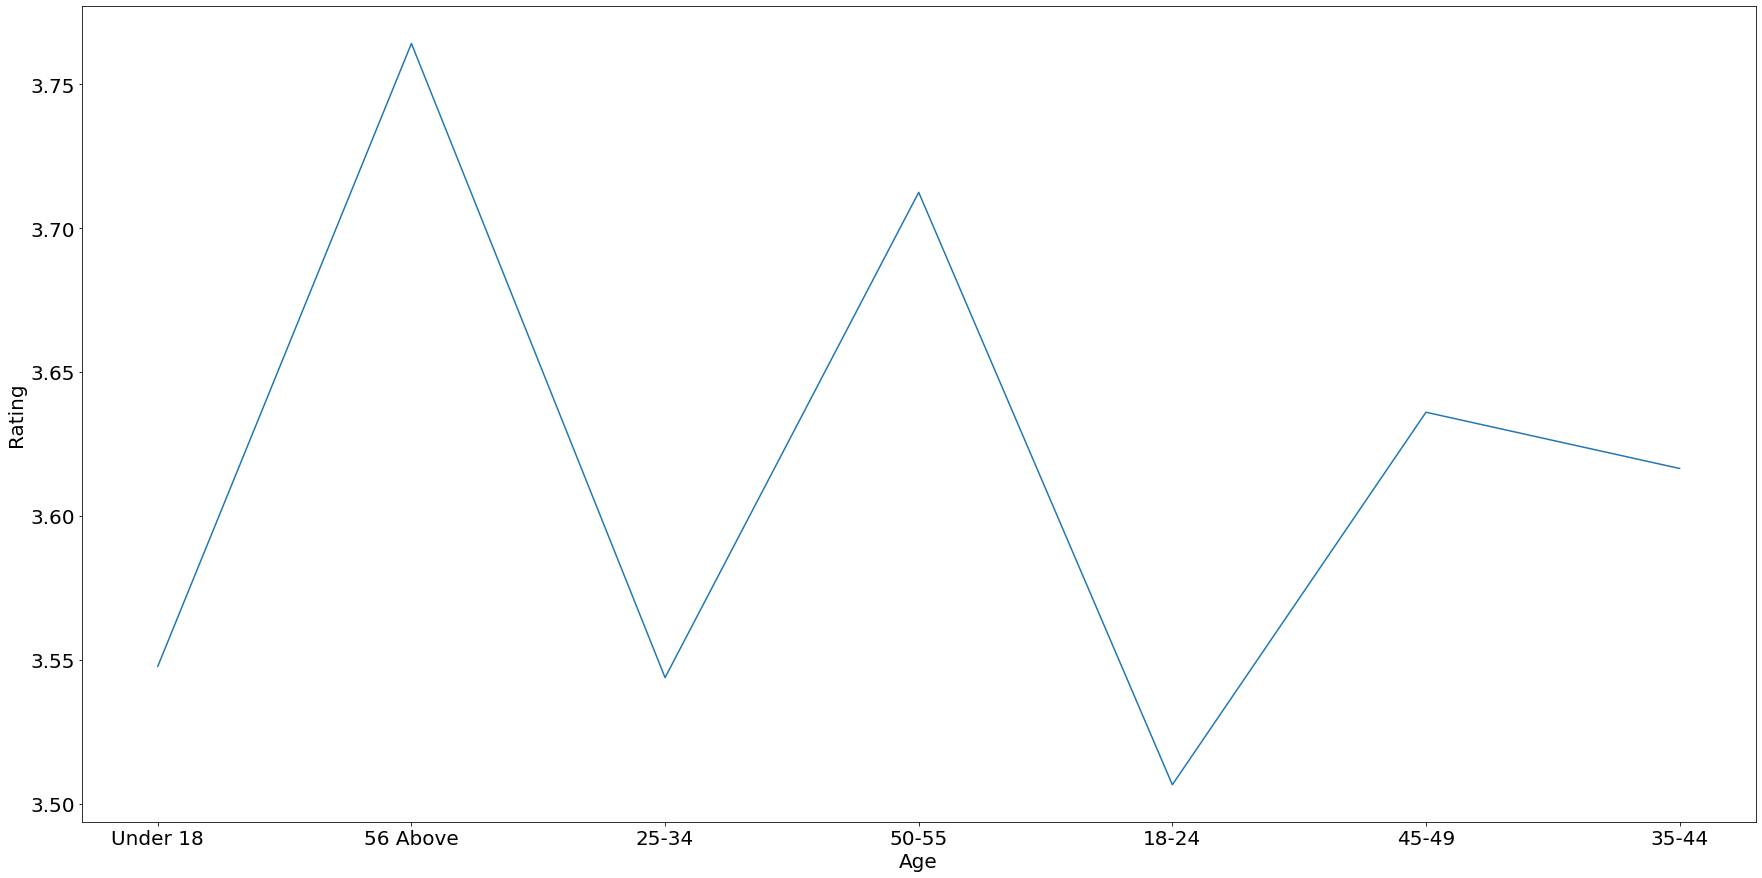

In [ ]:
# lineplot of Age with average rating
i='Age'
fig, ax = plt.subplots(figsize=(30, 15))
df_avg_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['mean']})
df_avg_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_avg_rating)
b.set_xlabel("Age",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

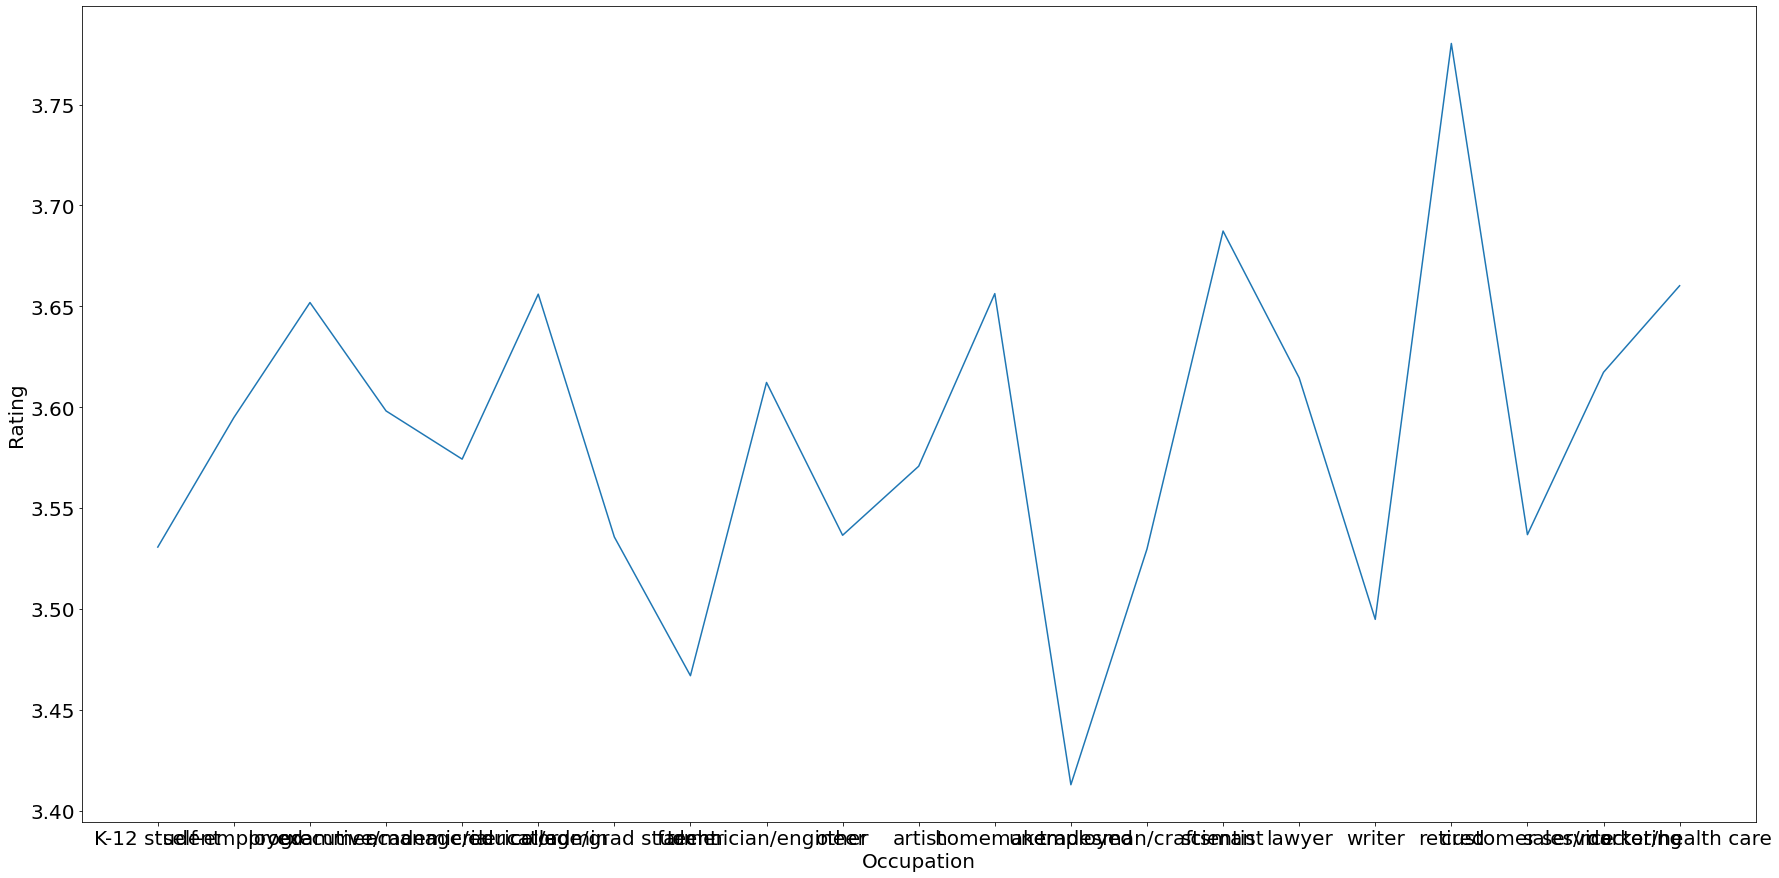

In [ ]:
# lineplot of Occupation with average rating
i='Occupation'
fig, ax = plt.subplots(figsize=(30, 15))
df_avg_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['mean']})
df_avg_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_avg_rating)
b.set_xlabel("Occupation",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

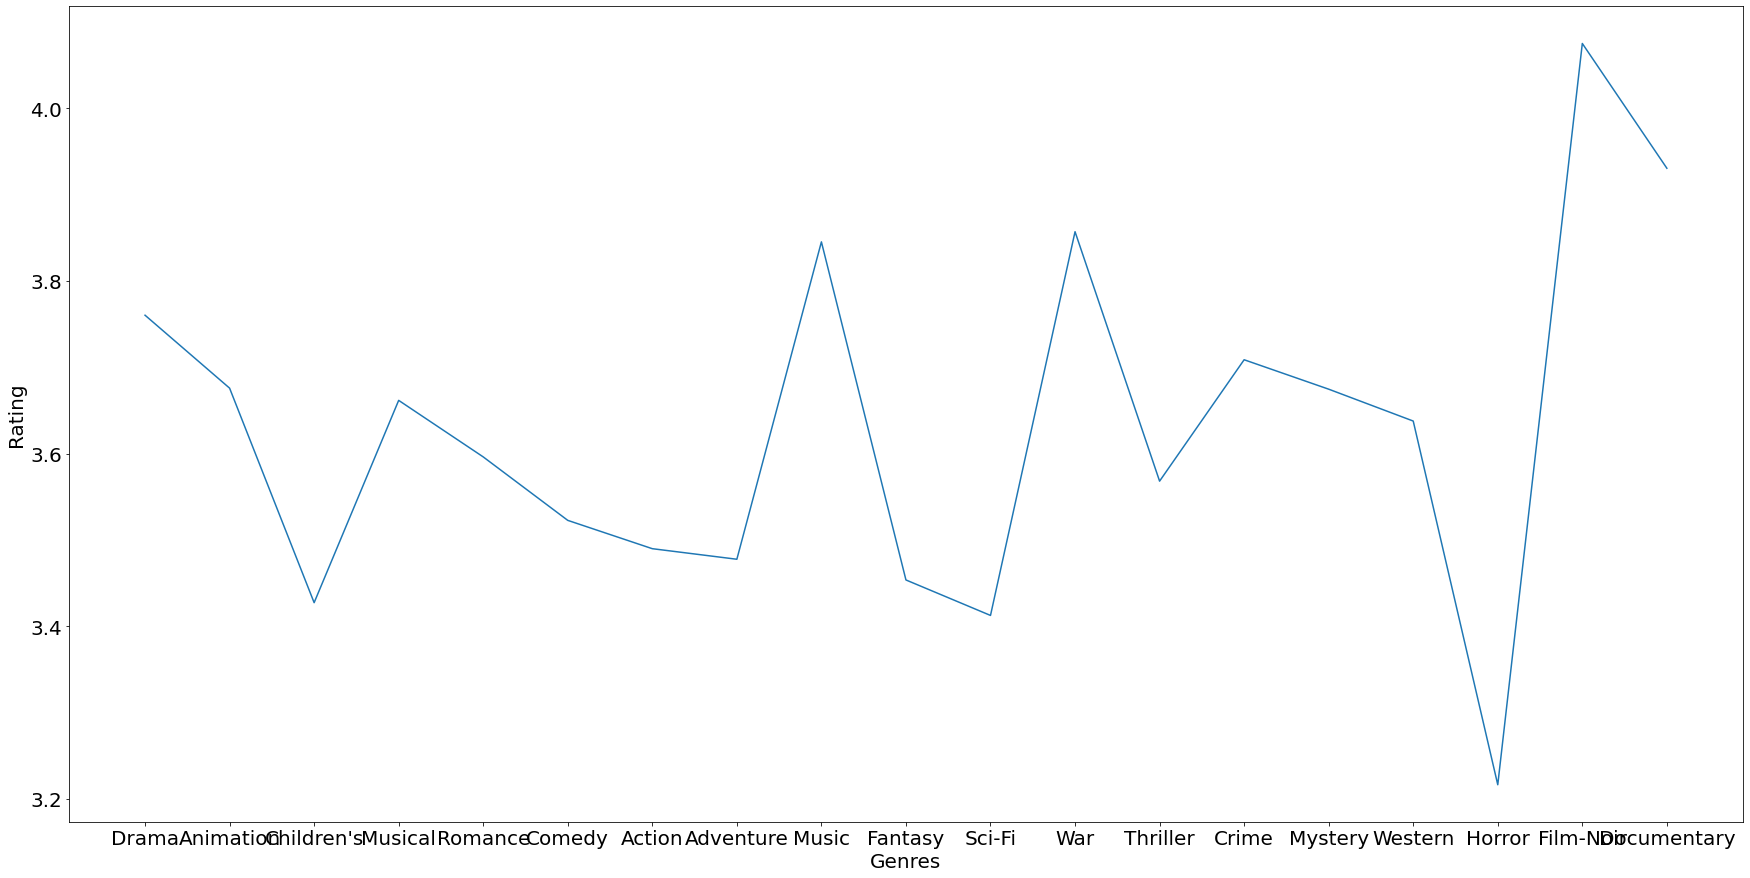

In [ ]:
# lineplot of Genres with average rating
i='Genres'
fig, ax = plt.subplots(figsize=(30, 15))
df_avg_rating = df_temp.groupby(i, as_index=False, sort=False).agg({'Rating': ['mean']})
df_avg_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_avg_rating)
b.set_xlabel("Genres",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

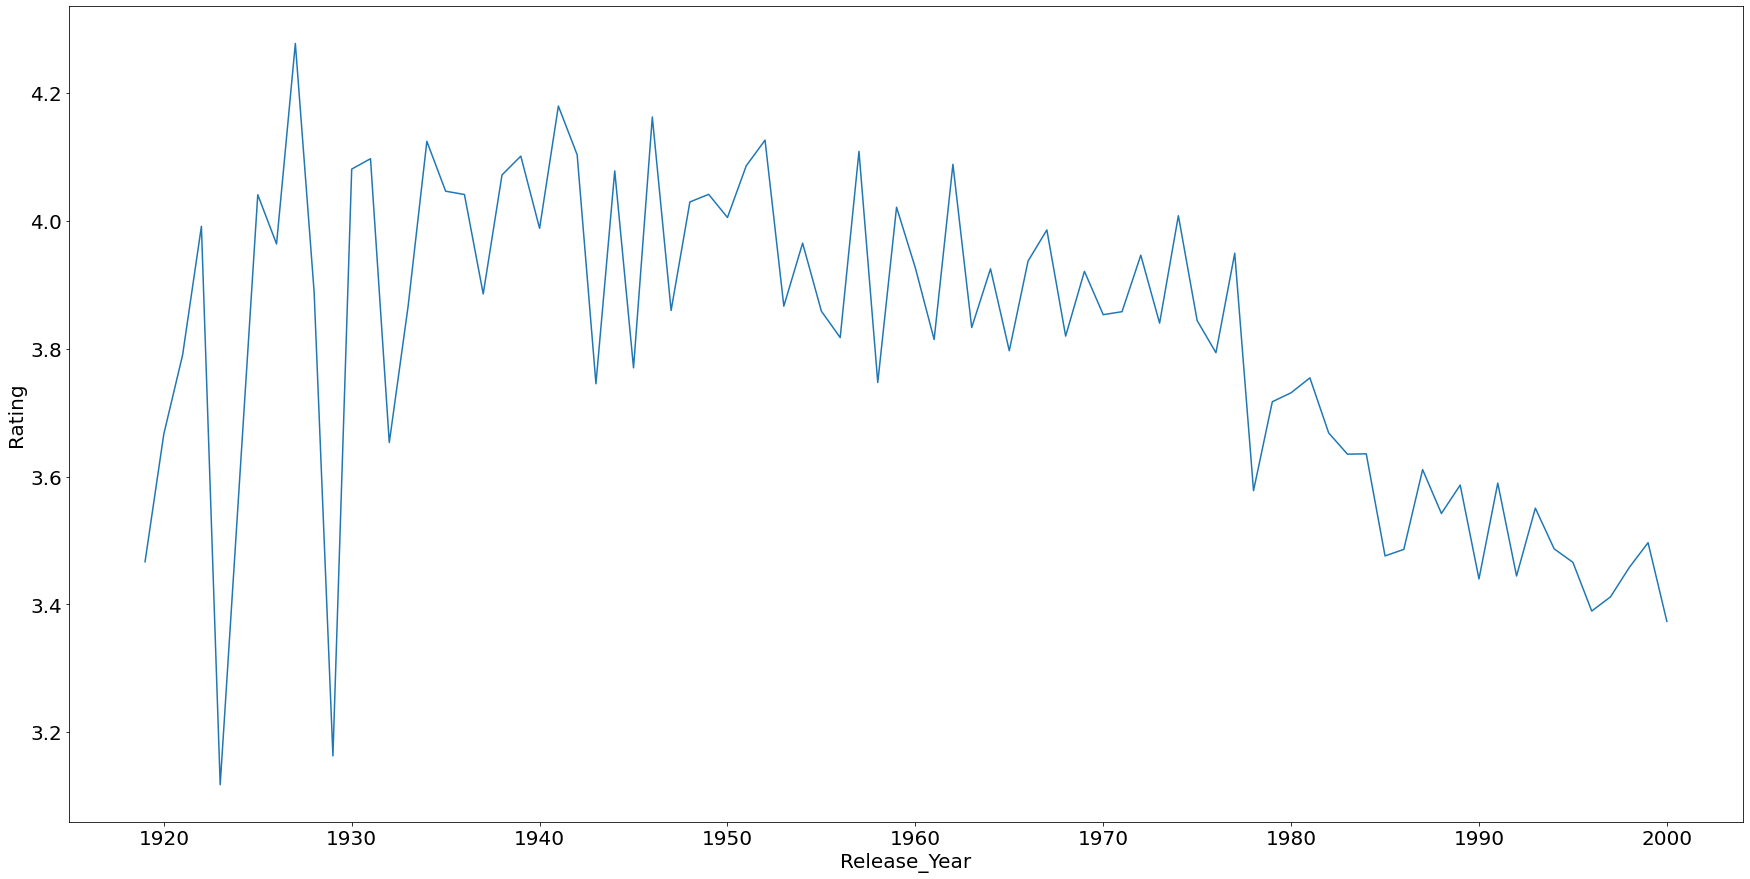

In [ ]:
# lineplot of Release_Year with average rating
i='Release_Year'
fig, ax = plt.subplots(figsize=(30, 15))
df_avg_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['mean']})
df_avg_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_avg_rating)
b.set_xlabel("Release_Year",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

#### Grouping the data in terms of No. of Ratings

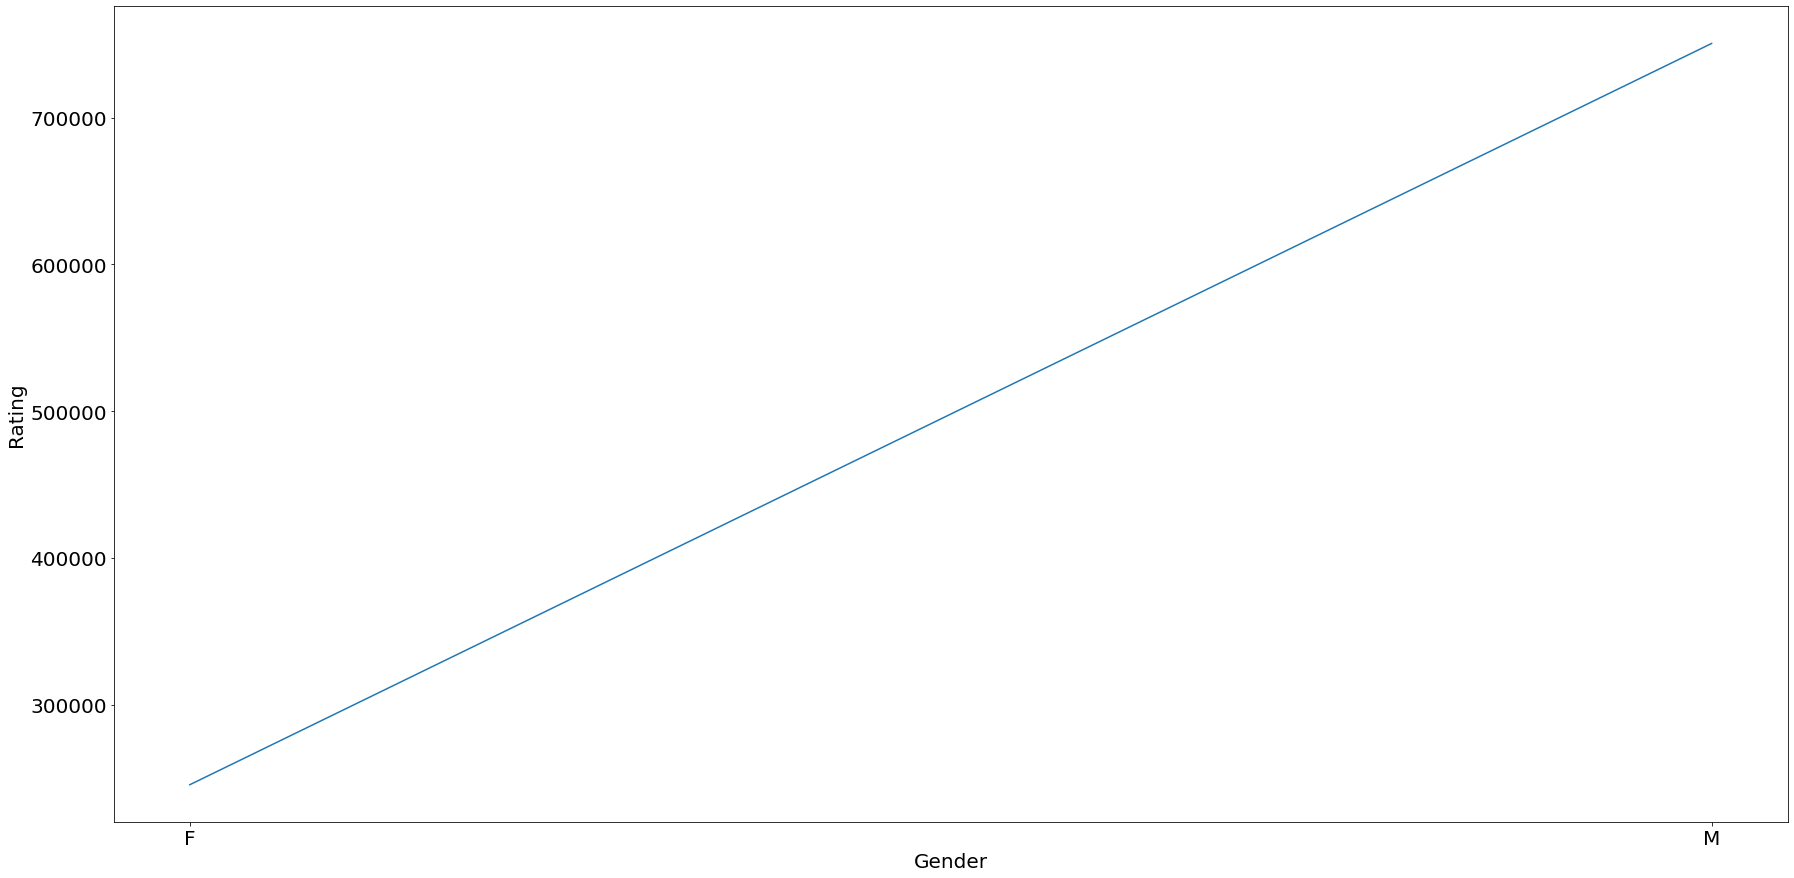

In [ ]:
# lineplot of Gender with no. of ratings
i='Gender'
fig, ax = plt.subplots(figsize=(30, 15))
df_count_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['count']})
df_count_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_count_rating)
b.set_xlabel("Gender",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

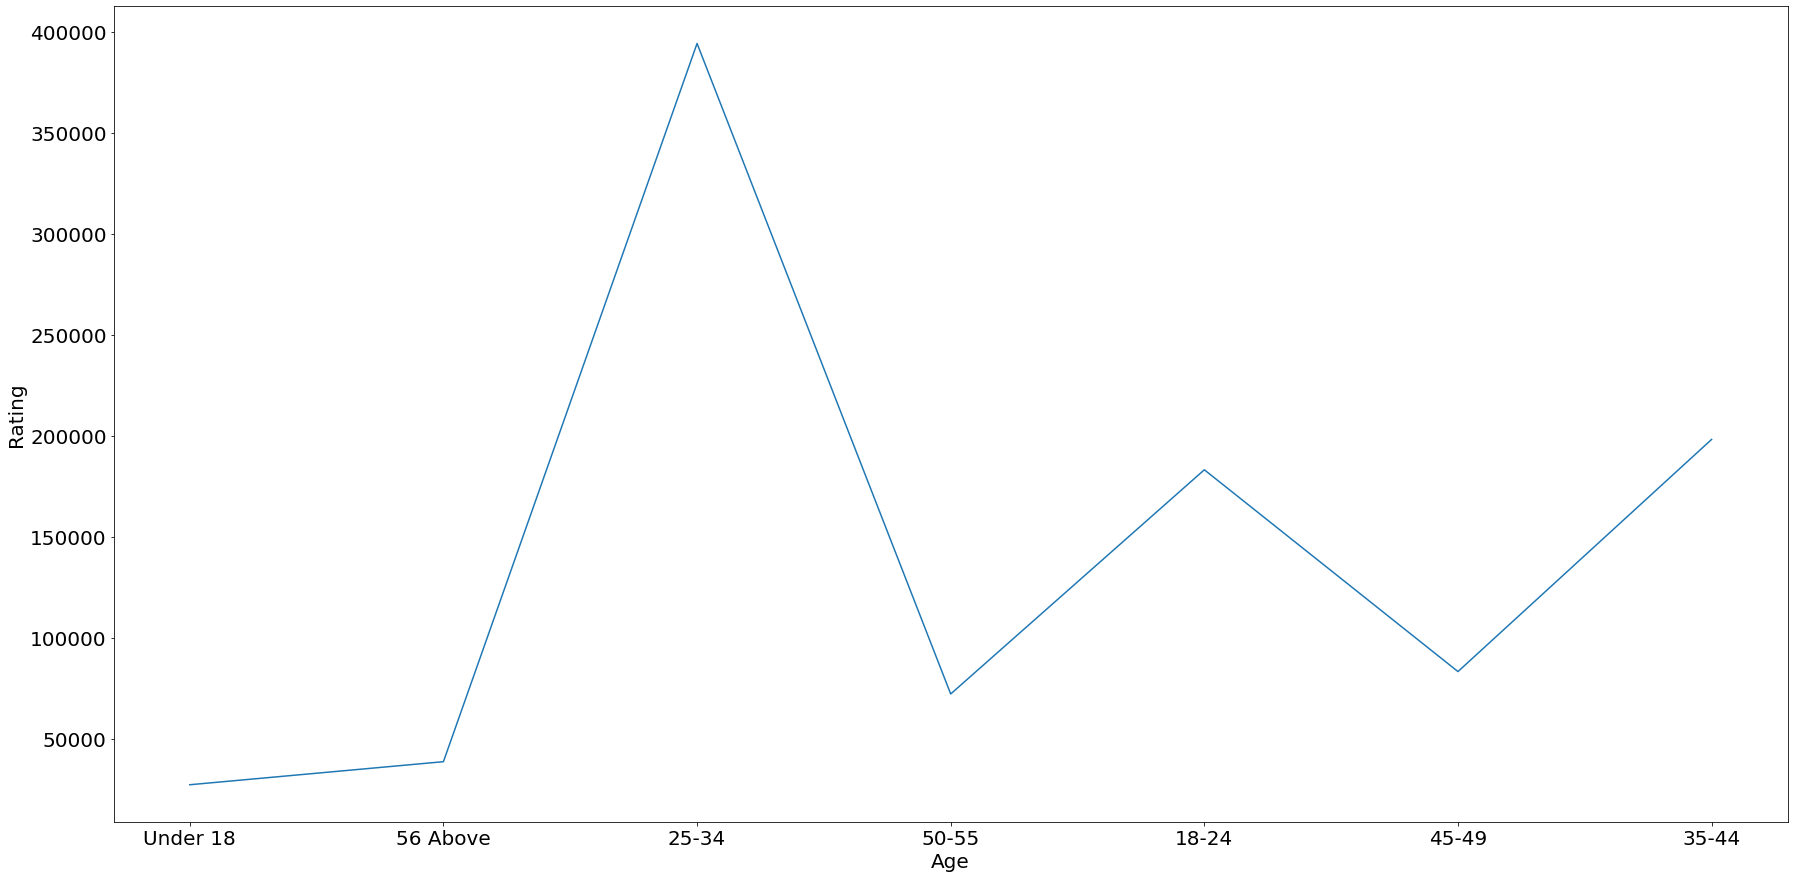

In [ ]:
# lineplot of Age with no. of ratings
i='Age'
fig, ax = plt.subplots(figsize=(30, 15))
df_count_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['count']})
df_count_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_count_rating)
b.set_xlabel("Age",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

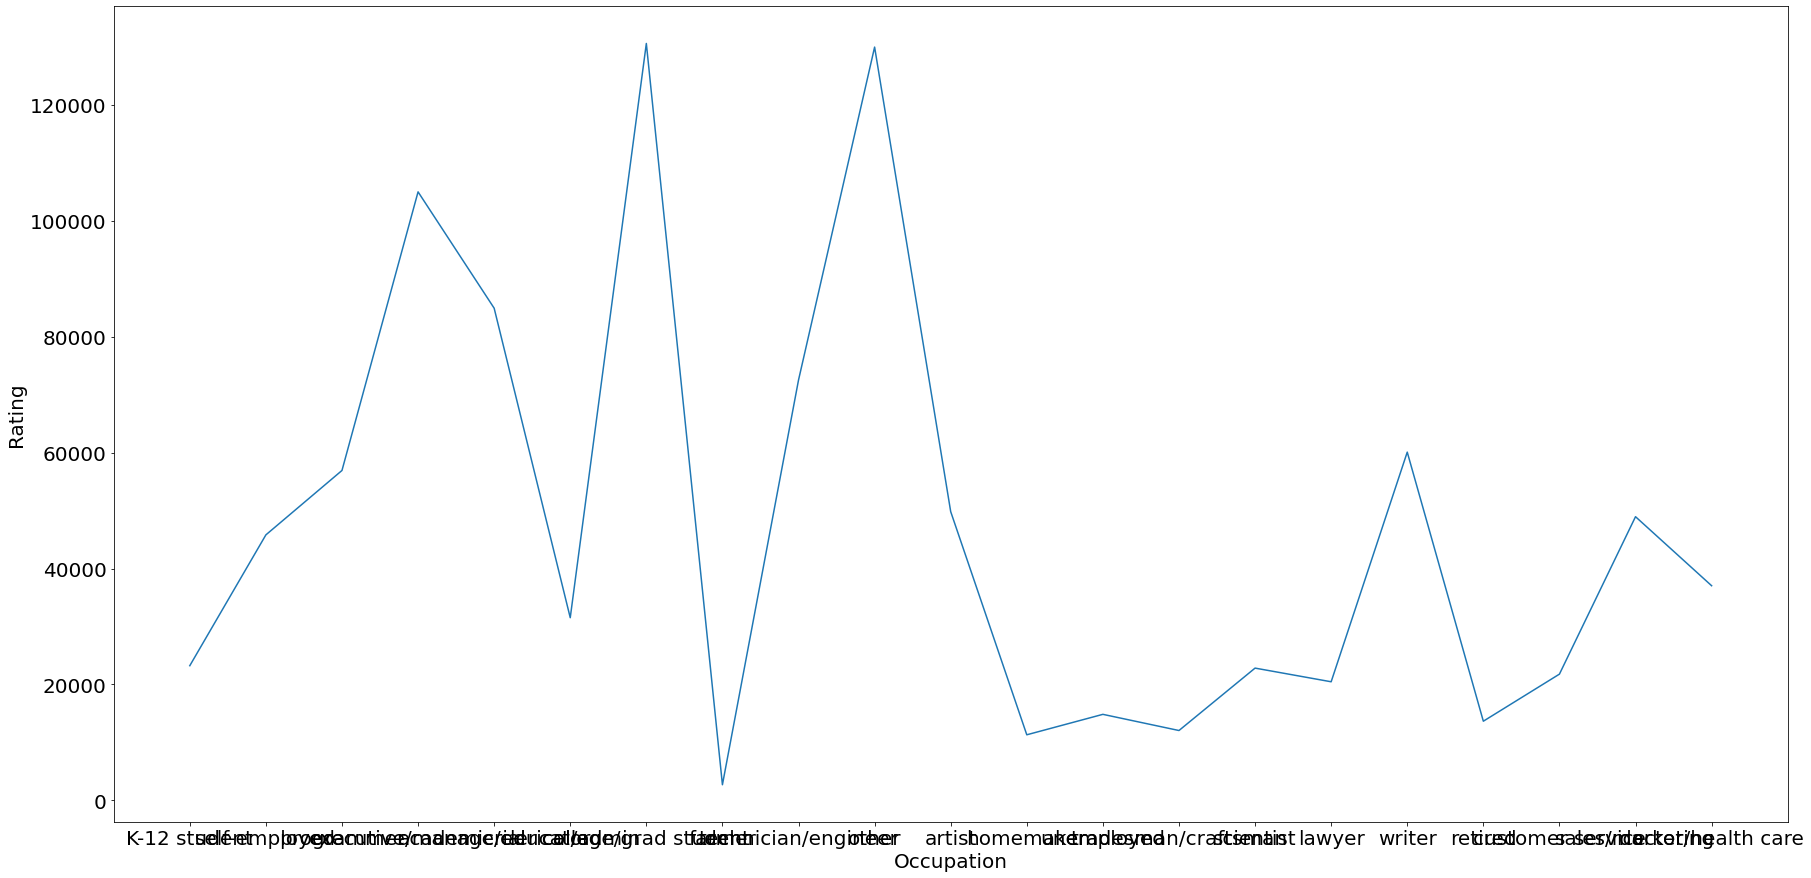

In [ ]:
# lineplot of Occupation with no. of ratings
i='Occupation'
fig, ax = plt.subplots(figsize=(30, 15))
df_count_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['count']})
df_count_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_count_rating)
b.set_xlabel("Occupation",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

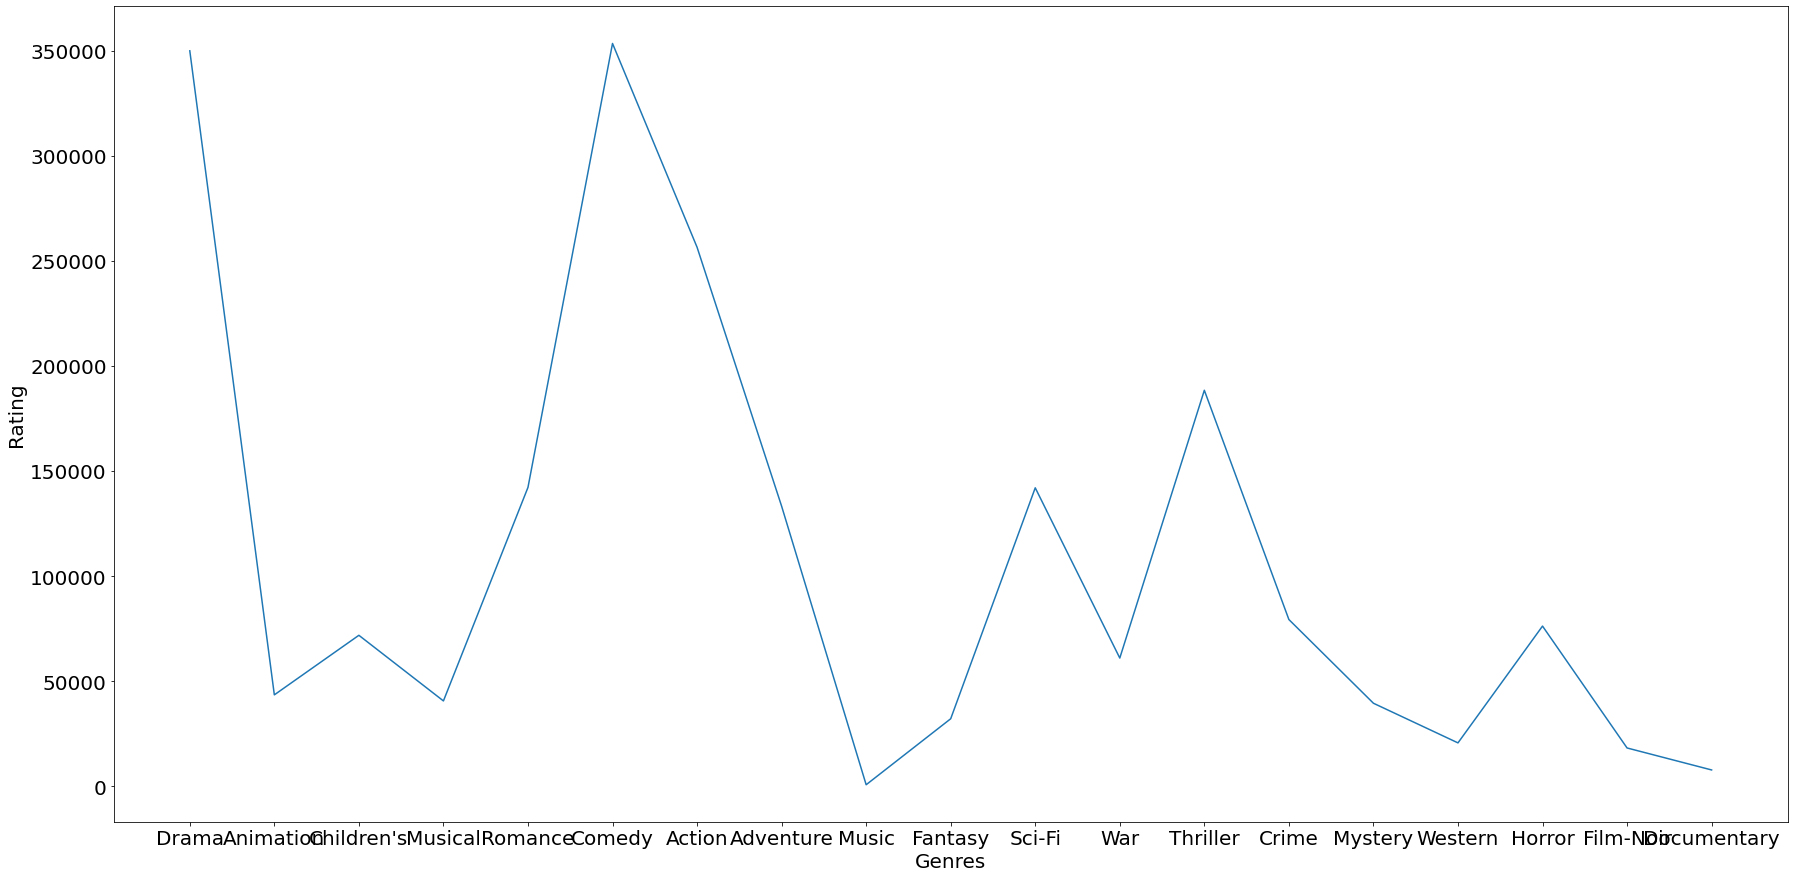

In [ ]:
# lineplot of Genres with no. of ratings
i='Genres'
fig, ax = plt.subplots(figsize=(30, 15))
df_count_rating = df_temp.groupby(i, as_index=False, sort=False).agg({'Rating': ['count']})
df_count_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_count_rating)
b.set_xlabel("Genres",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

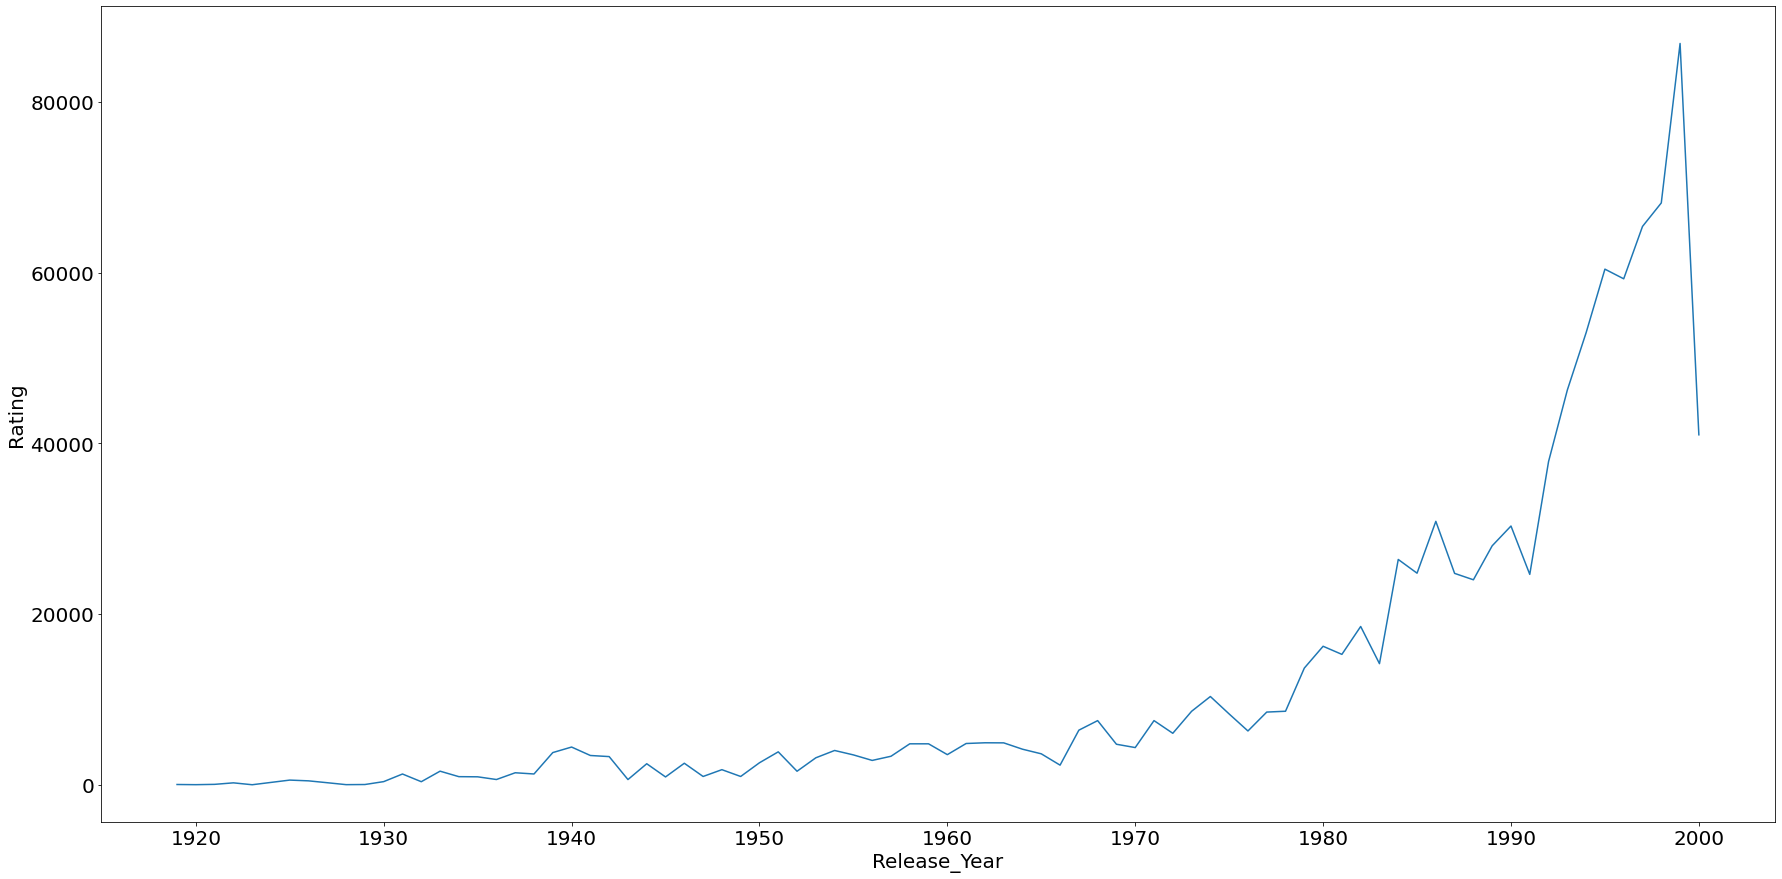

In [ ]:
# lineplot of Release_Year with no. of ratings
i='Release_Year'
fig, ax = plt.subplots(figsize=(30, 15))
df_count_rating = df.groupby(i, as_index=False, sort=False).agg({'Rating': ['count']})
df_count_rating.columns = [i, 'Rating']
b = sns.lineplot(x=i, y='Rating', data=df_count_rating)
b.set_xlabel("Release_Year",fontsize=20)
b.set_ylabel("Rating",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

In [ ]:
# Analysis to get most popular movies based on average rating and number of ratings (movies with over 100 ratings)
df_avg_count_rating = df.groupby('Title').agg(mean_rating = ('Rating', 'mean'),
                                      number_of_ratings = ('Rating', 'count')).reset_index()
df_avg_count_rating_100 = df_avg_count_rating[df_avg_count_rating['number_of_ratings']>100]

In [ ]:
# most popular movies based on average rating
df_avg_count_rating_100.sort_values(by='mean_rating', ascending=False).head()

,Title,mean_rating,number_of_ratings
2950,"Shawshank Redemption, The (1994)",4.554558,2227
1344,"Godfather, The (1972)",4.524966,2223
711,"Close Shave, A (1995)",4.520548,657
3480,"Usual Suspects, The (1995)",4.517106,1783
2882,Schindler's List (1993),4.510417,2304


In [ ]:
# most popular movies based on number of ratings
df_avg_count_rating_100.sort_values(by='number_of_ratings', ascending=False).head()

,Title,mean_rating,number_of_ratings
126,American Beauty (1999),4.317386,3428
3133,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3134,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
3135,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
1776,Jurassic Park (1993),3.763847,2672


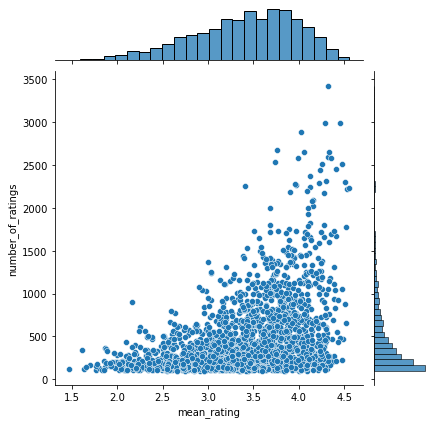

In [ ]:
# jointplot to get the correlation between the average rating and the no. of ratings
sns.jointplot(x='mean_rating', y='number_of_ratings', data=df_avg_count_rating_100)

### Preprocessing of data

In [ ]:
# creation of pivot table of movie titles & user id
item_table = pd.pivot(df,index='Title',columns='UserID',values='Rating')
item_table.head(10)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
101 Dalmatians (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# imputing NaN with 0 in pivot table
item_table.fillna(0,inplace=True)
item_table.head(10)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
101 Dalmatians (1961),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Aggregating the total number of users that voted and the total number of movies that received votes
count_user_voted_per_movie = df.groupby('Title')['Rating'].agg('count')
count_movies_voted_per_user = df.groupby('UserID')['Rating'].agg('count')

In [ ]:
# Removing movies who have rating from less than 10 users
item_table = item_table.loc[count_user_voted_per_movie[count_user_voted_per_movie > 10].index,:]

In [ ]:
# Removing users who have rated less than 10 movies
item_table = item_table.loc[:,count_movies_voted_per_user[count_movies_voted_per_user > 10].index]
item_table

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Your Friends and Neighbors (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Zed & Two Noughts, A (1985)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zero Effect (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Recommender System based on Pearson Correlation

In [ ]:
# Input movie name
movie_name = input('Enter movie name = ')

Enter movie name = Liar Liar (1997)


In [ ]:
# Implementation of Pearson Correlation RecSys
if movie_name in item_table.index:
    print("5 movies similar to '{}':".format(movie_name))
    print(item_table.T.corr()[movie_name].sort_values(ascending=False).iloc[1:6])
else:
    print("Movie not found in the final dataset")

5 movies similar to 'Liar Liar (1997)':
Title
Mrs. Doubtfire (1993)                0.499927
Dumb & Dumber (1994)                 0.459601
Ace Ventura: Pet Detective (1994)    0.458654
Home Alone (1990)                    0.455967
Wedding Singer, The (1998)           0.429222
Name: Liar Liar (1997), dtype: float64


### Recommender System based on Cosine Similarity

In [ ]:
# User-User similarity matrix using Pearson correlation
user_similarity = item_table.iloc[0:100,0:100].corr()
user_similarity.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.014358,-0.014358,-0.014358,-0.031340,0.489796,NaN,-0.024309,-0.014358,0.280944,...,0.489796,0.461672,0.129676,-0.014358,-0.025123,NaN,-0.028975,0.703526,0.417205,-0.024912
2,-0.014358,1.000000,-0.010101,-0.010101,-0.022049,-0.014358,NaN,-0.017102,-0.010101,0.197652,...,-0.014358,-0.043361,0.216778,-0.010101,-0.017675,NaN,-0.020385,-0.010101,-0.018735,-0.017526
3,-0.014358,-0.010101,1.000000,-0.010101,-0.022049,0.703526,NaN,-0.017102,-0.010101,-0.054938,...,-0.014358,0.120265,-0.034316,-0.010101,-0.017675,NaN,-0.020385,-0.010101,-0.018735,-0.017526
4,-0.014358,-0.010101,-0.010101,1.000000,-0.022049,-0.014358,NaN,-0.017102,-0.010101,0.197652,...,-0.014358,0.202079,0.300476,-0.010101,-0.017675,NaN,0.432606,-0.010101,-0.018735,-0.017526
5,-0.031340,-0.022049,-0.022049,-0.022049,1.000000,-0.031340,NaN,-0.037330,0.271934,-0.083163,...,-0.031340,-0.058933,-0.026187,-0.022049,-0.038581,NaN,-0.044496,-0.022049,-0.040895,-0.038257


In [ ]:
# Item-Item similarity matrix using Pearson correlation
item_similarity = item_table.T.iloc[0:100,0:100].corr()
item_similarity.head()

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",...,Aliens (1986),Alien³ (1992),Alive (1993),All About Eve (1950),All About My Mother (Todo Sobre Mi Madre) (1999),All Dogs Go to Heaven (1989),All Dogs Go to Heaven 2 (1996),All Over Me (1997),All Quiet on the Western Front (1930),All That Jazz (1979)
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother (1986),NaN,1.000000,-0.013607,-0.019891,-0.014073,-0.038683,-0.024779,-0.016352,-0.018606,-0.037543,...,-0.049185,-0.032866,-0.020328,-0.025032,-0.020427,-0.017495,-0.010101,-0.010101,-0.017495,-0.014268
'Til There Was You (1997),NaN,-0.013607,1.000000,-0.026795,-0.018958,0.249973,-0.033379,-0.022028,-0.025064,-0.050574,...,-0.066256,-0.044273,-0.027384,-0.033721,-0.027517,-0.023568,-0.013607,-0.013607,-0.023568,-0.019220
"'burbs, The (1989)",NaN,-0.019891,-0.026795,1.000000,-0.027713,0.302327,0.171329,-0.032201,0.204938,0.319048,...,0.341856,0.108634,-0.040030,0.176047,-0.040225,0.260850,-0.019891,-0.019891,0.260850,-0.028097
...And Justice for All (1979),NaN,-0.014073,-0.018958,-0.027713,1.000000,-0.053895,-0.034523,-0.022783,0.452661,-0.052307,...,0.031756,0.068685,-0.028322,0.383641,-0.028460,-0.024376,-0.014073,-0.014073,-0.024376,-0.019879


In [ ]:
# Creating KNN model with Cosine distance
item_table_matrix = csr_matrix(item_table.values)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(item_table_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Input movie name
movie_name = input('Enter movie name = ')

Enter movie name = Liar Liar (1997)


In [ ]:
# Picking up a random movie and calculating recommendations based on cosine distances
if movie_name in item_table.index:
    query_index = item_table.index.get_loc(movie_name)
    distances, indices = model_knn.kneighbors(np.array(item_table.iloc[query_index, :]).reshape(1,-1),
                                              n_neighbors=6)
    print("5 movies similar to '{}':".format(item_table.index[indices.flatten()[0]]))
    for i in range(1,len(distances.flatten())):
        print(item_table.index[indices.flatten()[i]])
else:
    print("Movie not found in the final dataset")

5 movies similar to 'Liar Liar (1997)':
Mrs. Doubtfire (1993)
Ace Ventura: Pet Detective (1994)
Dumb & Dumber (1994)
Home Alone (1990)
Wayne's World (1992)


### Recommender System based on Matrix Factorization

In [ ]:
# preparing data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

Q) How can you do a train test split for MF?

Answer - Train-test split for matrix factorization is typically done on the basis of user-item interactions. This means that some portion of the interactions in the interaction matrix (usually around 20-30%) is reserved as a test set and the rest is used as the training set. The training set is used to learn the user and item embeddings, and the test set is used to evaluate the accuracy of the model.

The aim of the train-test split is to simulate the real-world scenario where the model has to make recommendations for items that the user has not interacted with yet. The test set contains these interactions, and by comparing the predicted ratings to the true ratings, we can evaluate the performance of the model.

In [ ]:
# splitting the data for train and test as well as creating the model
train_data, test_data = train_test_split(data, test_size=.25)
model = SVD()
model.fit(train_data)

In [ ]:
# predictions on test data
predictions = model.test(test_data)

In [ ]:
# RMSE before tuning of model
accuracy.rmse(predictions)

RMSE: 0.8784


0.8784252413277805

In [ ]:
# Compute the MAPE on the predictions
def get_mape(predictions, verbose=False):
    true = [p.r_ui for p in predictions]
    pred = [p.est for p in predictions]
    mape = np.mean(np.abs((np.array(true) - np.array(pred)) / np.array(true))) * 100
    if verbose:
        print(f'MAPE: {mape:.2f}%')
    return mape

In [ ]:
# MAPE before tuning of model
mape = get_mape(predictions, verbose=True)
mape

MAPE: 26.62%


26.622809090026166

In [ ]:
# tuning of model
paramgrid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}

grid_search = GridSearchCV(SVD,
                          paramgrid,
                          measures=['rmse', 'mae'],
                          cv=3,
                          n_jobs=-1,
                          joblib_verbose=True)
grid_search.fit(data)
grid_search.best_score['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    8.2s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   12.3s finished


0.9026299046887426

In [ ]:
# best parameters for model
grid_search.best_params['rmse']

{'n_epochs': 10, 'lr_all': 0.005}

In [ ]:
# creating model with best parameters
model = SVD(n_epochs = 10, lr_all = 0.005, n_factors = 4)
model.fit(train_data)

In [ ]:
# predictions on test data
predictions = model.test(test_data)

In [ ]:
# RMSE after tuning of model
accuracy.rmse(predictions)

RMSE: 0.9079


0.9079064683875797

In [ ]:
# MAPE after tuning of model
mape = get_mape(predictions, verbose=True)
mape

MAPE: 28.12%


28.1226804678231

### Embeddings for item-item and user-user similarity

#### For d=4

In [ ]:
# preparing data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

In [ ]:
# Train the matrix factorization model
algo = surprise.SVD(n_factors=4)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
# Extract the item embeddings
item_embeddings = algo.qi
item_embeddings

array([[ 0.61435492, -0.07267889,  0.18210712, -0.4190905 ],
       [ 0.70438234,  0.05222875, -0.20631442, -0.09937662],
       [ 0.03374821, -0.33146159,  0.25577115,  0.19627744],
       ...,
       [ 0.09398918,  0.00356949,  0.11908984,  0.15869502],
       [ 0.07448463, -0.10675595, -0.06457492,  0.0849809 ],
       [-0.09671725,  0.10764635,  0.1343005 , -0.05613208]])

In [ ]:
# Extract the user embeddings
user_embeddings = algo.pu
user_embeddings

array([[ 0.05976013,  0.23585267, -0.08239326,  0.17865729],
       [-0.08940456, -0.13287274,  0.47275928,  0.29854478],
       [ 0.11411904, -0.0012536 , -0.00926434, -0.17760586],
       ...,
       [ 0.40921124, -0.00154177, -0.19943863, -0.12411629],
       [ 0.1365529 , -0.10354964, -0.1906118 , -0.10095952],
       [-0.10297914,  0.11377063, -0.06698257,  0.15603293]])

#### For d=2

In [ ]:
# preparing data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

In [ ]:
# Train the matrix factorization model
algo = surprise.SVD(n_factors=2)
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
# Extract the item embeddings
item_embeddings = algo.qi
item_embeddings

array([[-0.25606536, -0.54392547],
       [-0.17025504, -0.73621981],
       [-0.37022092,  0.50862096],
       ...,
       [ 0.23561505, -0.15851431],
       [ 0.13835384,  0.18245927],
       [ 0.03402747,  0.00490875]])

In [ ]:
# Extract the user embeddings
user_embeddings = algo.pu
user_embeddings

array([[ 0.12815954,  0.15825288],
       [ 0.2221308 ,  0.32533187],
       [ 0.01979082,  0.01839404],
       ...,
       [-0.46409041, -0.2015833 ],
       [-0.25480418,  0.04473532],
       [ 0.0932117 ,  0.08474063]])

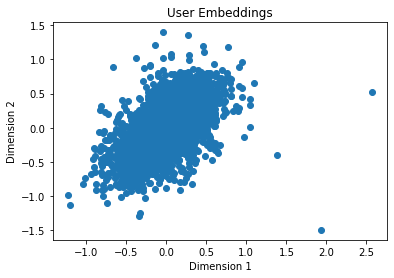

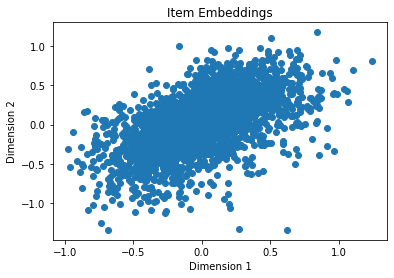

In [ ]:
# Plot the user embeddings
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("User Embeddings")
plt.show()

# Plot the item embeddings
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Item Embeddings")
plt.show()

The above plots suggests that the model has not been able to capture the distinct preferences and characteristics of users and items. This can be due to several reasons, such as:

1) Lack of data: If the interaction matrix has too few entries or the data is too sparse, the model may not be able to learn meaningful embeddings.

2) Poor model architecture: The choice of the matrix factorization model and the size of the embeddings can also impact the performance.

3) Overfitting: If the model is overfitting the training data, it may not be able to generalize to the test data and make accurate predictions.

This cluster of points around the center of the scatter plot suggests that the model has not captured the diversity of preferences and characteristics of the users and items.

### Questionnaire:

1) Users of which age group have watched and rated the most number of movies?

Answer: 25-34


2) Users belonging to which profession have watched and rated the most movies?

Answer: college/grad student


3) Most of the users in our dataset who’ve rated the movies are Male. (T/F)

Answer: True


4) Most of the movies present in our dataset were released in which decade - 70s b. 90s c. 50s d.80s?

Answer: 90s


5) The movie with maximum no. of ratings is ___.

Answer: American Beauty (1999)


6) Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

Answer:

a) Mrs. Doubtfire (1993)
        
b) Ace Ventura: Pet Detective (1994)
        
c) Dumb & Dumber (1994)
        
d) Home Alone (1990)
        
e) Wayne's World (1992)

        
7) On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

Answer: Item-based and User-based


8) Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

Answer: Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between 0 to 1.


9) Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

Answer: RMSE - 0.91 and MAPE - 28.1%


10) Give the sparse 'row' matrix representation for the following dense matrix -

[[1 0]

[3 7]]

Answer:

(0, 0)	1

(1, 0)	3
        
(1, 1)	7